<a href="https://colab.research.google.com/github/aiaaee/FasionMNIST/blob/main/Github_fasionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import shutil
import torch
import torch.nn.functional as f
from torch import nn , optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from tqdm import tqdm
from torch.utils.data import random_split

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
train_dataset = datasets.FashionMNIST('./data' , train=True , download=True , transform=ToTensor())
test_dataset = datasets.FashionMNIST('./data' , train=False , download=True ,  transform=ToTensor())

In [ ]:
train_ds , val_ds = random_split(train_dataset , [50000 , 10000])

In [ ]:
print('train dataset: '  , train_dataset.data.shape)
print('test dataset : '  , test_dataset.data.shape )

train dataset:  torch.Size([60000, 28, 28])
test dataset :  torch.Size([10000, 28, 28])


In [ ]:
input_size = [*train_dataset.data.shape[1:]]
num_epoches = 10
batch_size = 32
learning_rate = 0.01

In [ ]:
train_Dloader = DataLoader(train_ds , batch_size=batch_size , shuffle=True)
val_Dloader   = DataLoader(val_ds , batch_size=batch_size , shuffle=True )
test_Dloader  = DataLoader(test_dataset , batch_size=batch_size , shuffle=True)

In [ ]:
for data , label in train_Dloader :
  print(data.shape , label.shape)
  break

torch.Size([32, 1, 28, 28]) torch.Size([32])


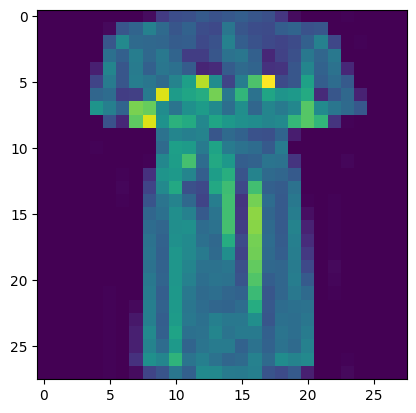

In [ ]:
plt.imshow(data[6, 0 , : , :])

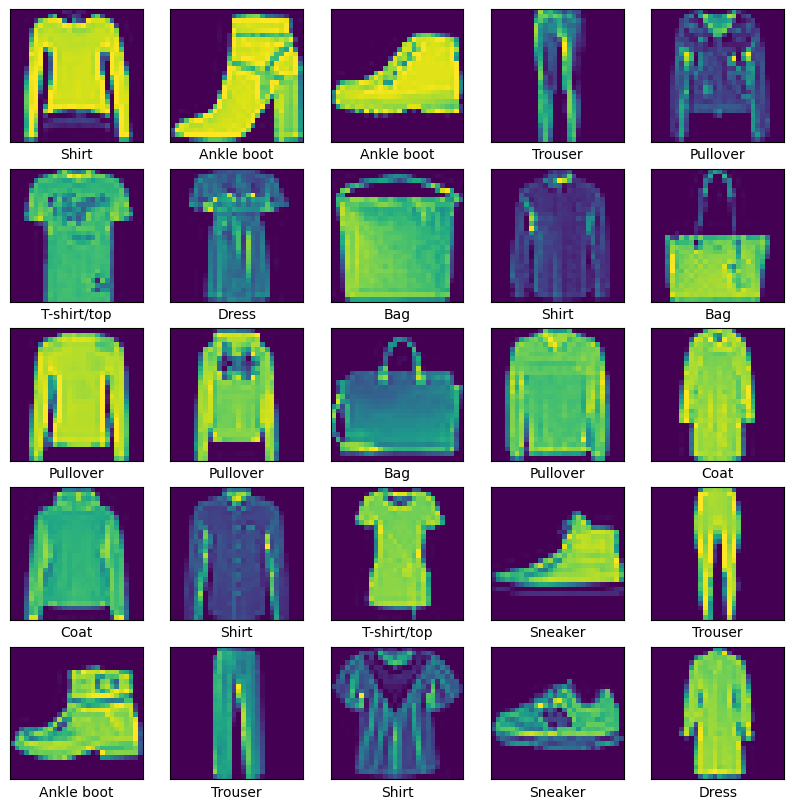

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat','Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(data[i , 0 , : , : ])
    plt.xlabel(class_names[label[i]])
plt.show()

In [ ]:
class NN(nn.Module):
  def __init__(self , in_feature:int , output_feature:int , *args , **kwargs):
    super().__init__(*args , kwargs)
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(in_feature , 300)
    self.bn1 = nn.BatchNorm1d(300)
    self.fc2 = nn.Linear(300 , 100)
    self.bn1 = nn.BatchNorm1d(100)
    self.fc2 = nn.Linear(100 , output_feature)
  def forward(self , x):
    x = self.flatten(x)
    output = self.bn1(self.fc1(x))
    output = nn.GELU()(output)
    output = self.bn2(self.fc2(output))
    output = nn.GELU()(output)
    return self.fc3(output)



In [ ]:
model = NeuralNet(784 , 10).to(device)

model

NeuralNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)

In [ ]:
#  A parameter that is assigned as an attribute inside a custom model is registered as a model parameter and is thus returned by the caller model. parameters().
model.parameters()

<generator object Module.parameters at 0x7838295dfbc0>

In [ ]:
#numel : Returns the total number of elements in the input tensor Parameters
counter = 1
for item in model.parameters():
  print("model parameters : " , counter)
  print(item.size())
  print(item.numel())
  counter +=1

model parameters :  1
torch.Size([300, 784])
235200
model parameters :  2
torch.Size([300])
300
model parameters :  3
torch.Size([100, 300])
30000
model parameters :  4
torch.Size([100])
100
model parameters :  5
torch.Size([10, 100])
1000
model parameters :  6
torch.Size([10])
10


In [97]:
from datetime import datetime

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
saving_path = 'saved_models/fashion_mnist'

# model description
print("-" * 20)
print("model: ", model)
model_total_params = sum(p.numel() for p in model.parameters())
model_total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("model total parameters: ", model_total_params)
print("model total trainable parameters: ", model_total_trainable_params)
print("-" * 20)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters() , lr=learning_rate)


--------------------
model:  NeuralNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)
model total parameters:  266610
model total trainable parameters:  266610
--------------------


In [99]:
num_epoches = 5
best_vloss = 1_000_000.
train_losses, val_losses = [], []

# Train & validate Network
for epoch in range(num_epoches):

    print(f'EPOCH {epoch + 1}:')

    running_loss = 0.
    last_loss = 0.

    model.train(True)
    for batch_idx, (data, targets) in enumerate(tqdm(train_Dloader)):

        data = data.to(device=device)
        targets = targets.to(device=device)

        # Make predictions for this batch (forward)
        outputs = model(data)

        # Compute the loss and its gradients
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        running_loss += loss.item()

        if batch_idx % 500 == 499:
            last_loss = running_loss / 500 # loss per batch
            print(f'batch {batch_idx + 1} loss: {last_loss}')
            running_loss = 0.

    running_vloss = 0.0
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, (vinputs, vlabels) in enumerate(val_Dloader):
            voutputs = model(vinputs)
            vloss = criterion(voutputs, vlabels)
            running_vloss += vloss
    avg_vloss = running_vloss / (i + 1)
    print(f'LOSS train {last_loss} valid {avg_vloss}')

    train_losses.append(last_loss)
    val_losses.append(avg_vloss)

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        if os.path.exists(saving_path):
            shutil.rmtree(saving_path)
        os.makedirs(saving_path)
        model_path = f'{saving_path}/model_{timestamp}_{epoch_number}.pth'
        torch.save(model.state_dict(), model_path)

    epoch_number += 1


EPOCH 1:


 32%|███▏      | 507/1563 [00:05<00:11, 88.10it/s]

batch 500 loss: 0.38236802965402605


 65%|██████▍   | 1010/1563 [00:12<00:06, 88.65it/s]

batch 1000 loss: 0.40144128777086735


 97%|█████████▋| 1515/1563 [00:18<00:00, 88.45it/s]

batch 1500 loss: 0.4087186375632882


100%|██████████| 1563/1563 [00:18<00:00, 83.91it/s]


LOSS train 0.4087186375632882 valid 0.39708006381988525
EPOCH 2:


 33%|███▎      | 512/1563 [00:06<00:11, 88.21it/s]

batch 500 loss: 0.41000579588115216


 65%|██████▍   | 1014/1563 [00:12<00:06, 87.16it/s]

batch 1000 loss: 0.38264771513640883


 97%|█████████▋| 1510/1563 [00:18<00:00, 89.49it/s]

batch 1500 loss: 0.3963139798939228


100%|██████████| 1563/1563 [00:19<00:00, 81.03it/s]


LOSS train 0.3963139798939228 valid 0.42432984709739685
EPOCH 3:


 33%|███▎      | 509/1563 [00:06<00:17, 58.59it/s]

batch 500 loss: 0.39583901096880436


 65%|██████▌   | 1018/1563 [00:12<00:06, 89.15it/s]

batch 1000 loss: 0.38997863909602165


 96%|█████████▋| 1505/1563 [00:18<00:00, 61.02it/s]

batch 1500 loss: 0.38054455564916134


100%|██████████| 1563/1563 [00:19<00:00, 79.29it/s]


LOSS train 0.38054455564916134 valid 0.39229804277420044
EPOCH 4:


 33%|███▎      | 519/1563 [00:06<00:11, 90.21it/s]

batch 500 loss: 0.3799115801304579


 65%|██████▍   | 1010/1563 [00:12<00:06, 83.50it/s]

batch 1000 loss: 0.37515084870159626


 97%|█████████▋| 1514/1563 [00:18<00:00, 91.68it/s]

batch 1500 loss: 0.38552095356583593


100%|██████████| 1563/1563 [00:19<00:00, 82.17it/s]


LOSS train 0.38552095356583593 valid 0.42581385374069214
EPOCH 5:


 33%|███▎      | 509/1563 [00:06<00:12, 84.67it/s]

batch 500 loss: 0.36725546085834504


 65%|██████▍   | 1010/1563 [00:12<00:06, 88.22it/s]

batch 1000 loss: 0.36761869649589063


 97%|█████████▋| 1510/1563 [00:19<00:00, 89.70it/s]

batch 1500 loss: 0.3613767917081714


100%|██████████| 1563/1563 [00:19<00:00, 79.30it/s]


LOSS train 0.3613767917081714 valid 0.43897348642349243


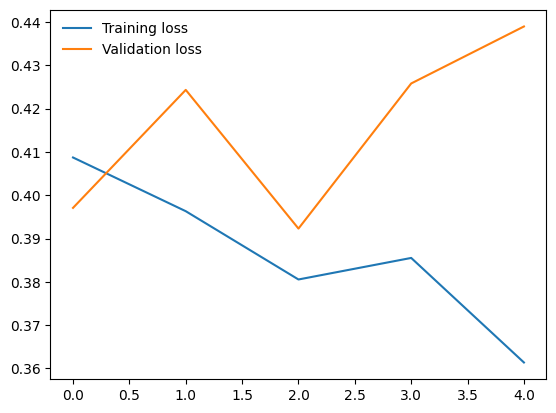

In [100]:
plt.plot(train_losses , label ="Training loss")
plt.plot(val_losses , label ="Validation loss")
plt.legend(frameon = False)